# Fetal immune Visium ST data - exploration 

In this notebook we load and visualize spatial transcriptomics data from human developing organs. See [our preprint] for more information on how this data was generated.

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Define some utility functions for plotting

In [6]:
# pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

def get_pixel_size_visium(adata, library_id, spot_diameter_real = 55, img='lowres'):
    '''
    Utility function to get size of pixels from visium image in AnnData.
    Useful to plot scalebars with matplotlib_scalebar.ScaleBar
    
    Params:
    -------
    - adata: AnnData object storing image info in adata.uns[spatial]
    - library_id: string storing ID for image, must be a key in adata.uns[spatial]
    - spot_diameter_real: numeric storing real diameter of spot, in whatever unit you need 
        (default is 55, for 55 microns of Visium 10X spots)
    - img: which image to use (default: lowres)
    '''

    ## get scale factor converting original pixel positions (adata.obsm['spatial']) to 
    # pixel positions in image
    scalef = adata.uns['spatial'][library_id]['scalefactors']['tissue_{i}_scalef'.format(i=img)]
    ## get spot diameter in image pixels
    spot_diameter_img = adata.uns['spatial'][library_id]['scalefactors']['spot_diameter_fullres'] * scalef
    ## Calculate pixel size
    pixel_size_real = spot_diameter_real/spot_diameter_img
    return(pixel_size_real)

### Load data

AnnData objects in `.h5ad` format can be downloaded from [here](). In this example we explore the data from fetal thymus.  

In [7]:
th_data_file = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/Visium_data/Visium10X_data_SP.h5ad'
# th_data_file = '/path/to/data/Visium10X_data_TH.h5ad'

In [8]:
adata = sc.read_h5ad(th_data_file)

In [9]:
adata

AnnData object with n_obs × n_vars = 10787 × 14013
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'img_id', 'EXP_id', 'Organ', 'Fetal_id', 'SN', 'Visium_Area_id', 'Age_PCW', 'Digestion time', 'paths', 'sample_id', '_scvi_batch', '_scvi_labels', '_indices', 'total_cell_abundance'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt'
    uns: 'NMF_celltype_fractions', '_scvi', 'mod', 'spatial', 'spatial_neighbors'
    obsm: 'NMF', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'
    obsp: 'spatial_connectivities', 'spatial_distances', 'spatial_distances_all'

Sample names are stored in `adata.obs['sample']` 

In [10]:
adata.obs['sample'].unique()

['WSSS_F_IMMsp9838710', 'WSSS_F_IMMsp9838715', 'WSSS_F_IMMsp10864181', 'WSSS_F_IMMsp10864182']
Categories (4, object): ['WSSS_F_IMMsp9838710', 'WSSS_F_IMMsp9838715', 'WSSS_F_IMMsp10864181', 'WSSS_F_IMMsp10864182']

We can use a helper function to subset data for plotting

In [11]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :].copy()
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

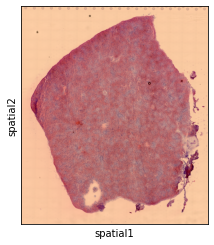

In [12]:
sdata = select_slide(adata, 'WSSS_F_IMMsp9838710')
sc.pl.spatial(sdata)

### Visualize spatial expression of a gene

In [13]:
## Set var names to gene names 
adata.var_names = adata.var['SYMBOL'].copy()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


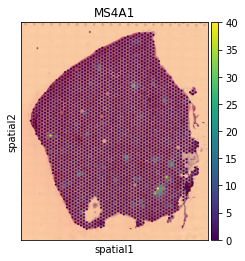

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


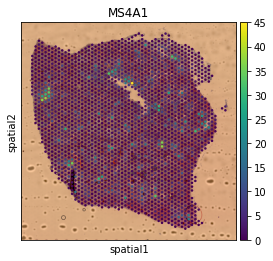

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


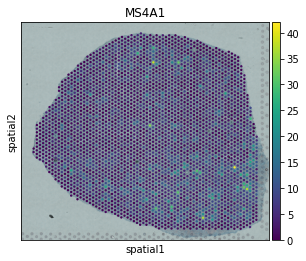

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


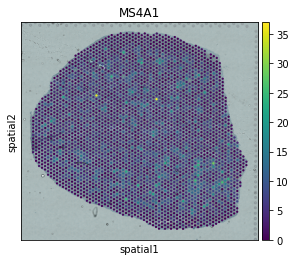

In [14]:
for s in adata.obs['sample'].unique():
    sdata = select_slide(adata, s)
    sc.pl.spatial(sdata, color='MS4A1')

### Visualize estimated spatial cell type abundances

The outputs from `cell2location` are stored in the anndata object. `adata_vis.obsm['q05_cell_abundance_w_sf']` stores the matrix of cell type abundances for each spot

In [15]:
adata.obsm['q05_cell_abundance_w_sf']
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf'].copy()
adata.obs[adata.uns['mod']['factor_names']]

,ABT(ENTRY),B1,CD4+T,CD8+T,CD8AA,CMP,CYCLING_B,CYCLING_DC,CYCLING_FIBROBLAST_I,CYCLING_ILC,...,PROMONOCYTE,PROMYELOCYTE,PRO_B,SMALL_PRE_B,TREG,TYPE_1_INNATE_T,TYPE_3_INNATE_T,VSMC_PERICYTE,VSMC_PERICYTE_III,YS_ERY
spot_id,,,,,,,,,,,,,,,,,,,,,
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACAAGTATCTCCCA-1,0.005560,0.003613,0.003032,0.002029,0.000373,0.000910,0.000891,0.000792,0.074247,0.009407,...,0.002114,0.006833,0.034715,0.179772,0.006586,0.011501,0.001752,0.019907,0.022872,0.247301
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACAGCTTTCAGAAG-1,0.065115,0.063198,0.043080,0.030761,0.005955,0.014492,0.028479,0.002727,0.775620,0.093111,...,0.006540,0.044404,0.318672,1.041328,0.057932,0.099771,0.020567,0.110398,0.231668,1.281945
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACAGGGTCTATATT-1,0.058271,0.054168,0.040419,0.028955,0.010610,0.011543,0.027114,0.036305,0.662373,0.115121,...,0.011537,0.041940,0.259276,0.896266,0.075049,0.097214,0.026565,1.549718,0.235948,1.177847
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACCGGGTAGGTACC-1,0.043202,0.037373,0.024085,0.016678,0.003057,0.004763,0.014098,0.001013,0.491423,0.065907,...,0.002754,0.022595,0.153230,0.696052,0.040501,0.074931,0.013660,0.095376,0.122800,1.317721
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACCGTTCGTCCAGG-1,0.024190,0.022848,0.012205,0.010713,0.005882,0.003899,0.008402,0.067075,2.525347,0.058374,...,0.004825,0.013269,0.162365,0.601731,0.038711,0.050560,0.011793,2.747409,0.117751,0.509596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSSS_F_IMMsp10864182_TTGTTTCACATCCAGG-1,0.431505,4.527680,1.983528,1.587750,5.188672,1.751529,2.225215,0.856851,0.033770,0.045191,...,0.117028,0.033685,0.029567,0.071399,0.172796,0.163304,1.311332,3.936801,0.031098,0.053151
WSSS_F_IMMsp10864182_TTGTTTCATTAGTCTA-1,0.137345,1.781288,0.616707,0.505919,0.485451,1.140429,0.908496,0.297090,0.163025,0.018401,...,0.079140,0.034364,0.045067,0.104571,0.049408,0.082422,0.369606,2.211761,0.040901,0.154717
WSSS_F_IMMsp10864182_TTGTTTCCATACAACT-1,0.132442,2.253372,0.680608,0.549745,0.490810,1.727760,1.019701,0.144422,0.021162,0.014279,...,0.059780,0.036894,0.011691,0.052908,0.052999,0.068317,0.476777,0.869702,0.032634,0.149152


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


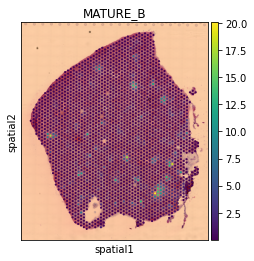

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


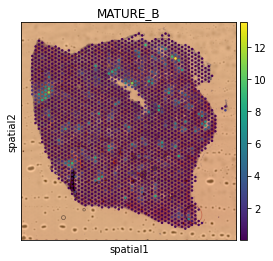

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


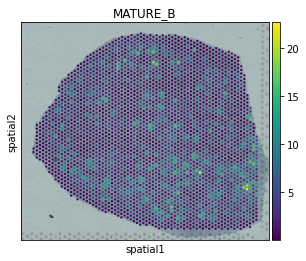

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


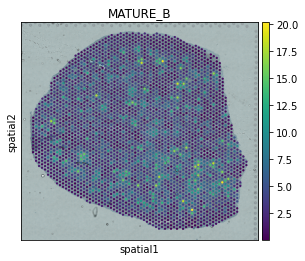

In [16]:
for s in adata.obs['sample'].unique():
    sdata = select_slide(adata, s)
    sc.pl.spatial(sdata, color='MATURE_B')

### Visualize tissue microenvironments

Values for NMF factors representing microenvironments of co-localized cell types are stored in `adata.obsm['NMF']`

In [17]:
adata.obsm['NMF']

,fact_0,fact_1,fact_2,fact_3,fact_4,fact_5,fact_6,fact_7,fact_8,fact_9
spot_id,,,,,,,,,,
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACAAGTATCTCCCA-1,4.193691,11.889375,32.031508,0.000000,1.158498,0.997304,6.934229,6.010814,2.680109,1.003598
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACAGCTTTCAGAAG-1,14.108431,3.623894,91.833144,0.746582,0.569610,1.351036,17.012474,17.257858,10.417919,1.178475
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACAGGGTCTATATT-1,9.168620,12.250866,87.956934,0.602725,6.362675,1.088699,15.404487,15.866499,8.639267,7.980038
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACCGGGTAGGTACC-1,13.114541,7.328292,72.176703,0.785708,0.846002,0.346139,20.828822,8.862998,4.809917,1.034298
spaceranger130_count_36654_WSSS_F_IMMsp9838710_GRCh38-2020-A_AAACCGTTCGTCCAGG-1,18.214192,0.000000,60.947212,0.000000,12.460522,0.000000,0.000000,9.516932,18.569500,10.931182
...,...,...,...,...,...,...,...,...,...,...
WSSS_F_IMMsp10864182_TTGTTTCACATCCAGG-1,5.940916,14.722124,3.422321,34.896101,7.024408,40.497208,7.285159,7.458414,4.871684,7.947516
WSSS_F_IMMsp10864182_TTGTTTCATTAGTCTA-1,4.826921,15.447177,13.351793,10.454938,6.966056,23.669459,8.658637,10.987653,7.018309,5.306924
WSSS_F_IMMsp10864182_TTGTTTCCATACAACT-1,9.646552,17.765564,1.829527,9.573790,2.808374,26.774726,15.892248,5.685692,1.734719,1.267615


In [18]:
## Add factors to obs for visualization
if adata.obsm["NMF"].columns[0] in adata.obs.columns:
    adata.obs = adata.obs.drop(adata.obsm["NMF"].columns, 1).copy()
adata.obs = pd.concat([adata.obs, adata.obsm["NMF"]], 1)

In [19]:
s = 'WSSS_F_IMMsp9838715'

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


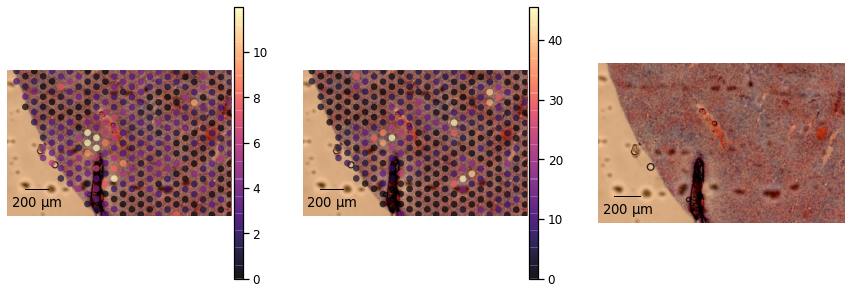

In [25]:
nrow=1
ncol=3
coords = [2300, 4535,4594,6045]

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs = axs.reshape((nrow, ncol))

from itertools import chain
ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
sdata = select_slide(adata, s)
lib_id = [x for x in sdata.uns['spatial'].keys()][0]
pix_size = get_pixel_size_visium(sdata, lib_id, img='hires')
for i, c in enumerate(['fact_3', 'fact_5', None]):
    # c='fact_9'
    if c is not None:
        vmax = np.quantile(sdata.obs[c].values, 0.992)
        vmin=0
        spot_alpha=0.7
    else:
        vmax=None
        vmin=None
        spot_alpha=0
    sns.set_context("notebook", font_scale=1.1)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.rcParams['axes.titlesize'] = 32
    sc.pl.spatial(sdata, color=c, ncols=1, size=1, 
                          vmin=vmin, vmax=vmax, crop_coord=coords, alpha=spot_alpha,
                          cmap="magma", frameon=False, title="", 
                          ax=axs[ind[i][0],ind[i][1]], show=False,
                          img_key='hires')
    ## add scalebars
    scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='lower left')
    axs[ind[i][0],ind[i][1]].add_artist(scalebar)

figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/spatial_mapping_EDA/"
fig.savefig(figdir + 'spl_lymph_aggregates_zoom.pdf')

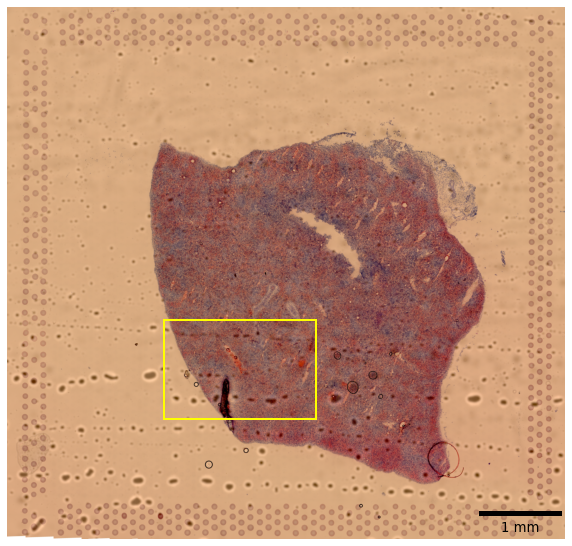

In [23]:
fig, ax = plt.subplots(1,1)
ax.imshow(adata.uns['spatial'][lib_id]['images']['hires'])
ax.axis('off')

## add scalebars
scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='lower left')
ax.add_artist(scalebar)

# write rectangle on plot (for extract)
sf = adata.uns['spatial'][lib_id]['scalefactors']['tissue_hires_scalef']
rect = matplotlib.patches.Rectangle((coords[0]*sf,coords[2]*sf), 
                                    width=(coords[1]-coords[0])*sf, 
                                    height=(coords[3]-coords[2])*sf, 
                                    ec='yellow', lw=2, fill=False)
ax.add_patch(rect)
fig.savefig(figdir + 'spl_lymph_aggregates_zoom_inset.pdf')

In [24]:
help(ScaleBar)

Help on class ScaleBar in module matplotlib_scalebar.scalebar:

class ScaleBar(matplotlib.artist.Artist)
 |  ScaleBar(dx, units='m', dimension='si-length', label=None, length_fraction=None, height_fraction=None, width_fraction=None, location=None, loc=None, pad=None, border_pad=None, sep=None, frameon=None, color=None, box_color=None, box_alpha=None, scale_loc=None, label_loc=None, font_properties=None, label_formatter=None, scale_formatter=None, fixed_value=None, fixed_units=None, animated=False, rotation=None)
 |  
 |  Abstract base class for objects that render into a FigureCanvas.
 |  
 |  Typically, all visible elements in a figure are subclasses of Artist.
 |  
 |  Method resolution order:
 |      ScaleBar
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dx, units='m', dimension='si-length', label=None, length_fraction=None, height_fraction=None, width_fraction=None, location=None, loc=None, pad=None, border_pad=None,

In [ ]:
c='fact_3'
vmax = np.quantile(_select_lib_spots(adata, l).obs[c].values, 0.992)
sns.set_context("notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['axes.titlesize'] = 32
sc.pl.spatial(_select_lib_spots(adata, l), color=c, library_id=l,ncols=1, size=1, 
                      vmin=0, vmax=vmax,crop_coord=coords, alpha=0.5,
                      cmap="viridis", frameon=False, title="",
#                       ax=axs[ind[pos_ix][0],ind[pos_ix][1]], show=False,
                      img_key='hires')